# YOUR PROJECT TITLE

> **Note the following:** 
> 1. This is *not* meant to be an example of an actual **model analysis project**, just an example of how to structure such a project.
> 1. Remember the general advice on structuring and commenting your code
> 1. The `modelproject.py` file includes a function which could be used multiple times in this notebook.

Imports and set magics:

In [31]:
import numpy as np
from scipy import optimize
import sympy as sm
from sympy.solvers import solve
# for later use, in order to write tilde-variables, we need the following package
from sympy import *
sm.init_printing()

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# local modules
import modelproject

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Model description

**The Solow model with human kapital** 

The extendet Solow model contain the following variables
1. $K_t$ is physical capital
2. $H_t$ is human capital
3. $A_t$ is technology
4. $L_t$ is labour

The production function
$$
Y_t = K_t^{\alpha}H_t^{\varphi}(A_tL_t)^{1-\alpha-\varphi}, \quad 0<\alpha<1, 0<\varphi<1, \alpha+\varphi<1
$$

The household decides how much to save of physical capital and of human capital as a constant fraction of income.
$$
S_t = (s_K + s_H)Y_t, \quad s_K+s_H<1
$$

$s_K$ denotes the savings rate of physical capital and $s_H$ denotes the savings of human capital

This lead to the accumulation of phycial capital
$$
K_{t+1}=s_KY_t+(1-\delta)K_t, \quad K_0 \, \text{given}
$$

As well as the accumulation of human capital
$$
H_{t+1}=s_HY_t+(1-\delta)H_t, \quad H_0 \, \text{given}
$$

Further more the accumulation of technology and labour is defined as following
$$
A_{t+1} = (1+g)A_t, \quad A_0 \, \text{given}
$$
$$
L_{t+1} = (1+n)L_t, \quad L_0 \, \text{given}
$$
Where  $g$ is a constant rate of techonolical progress, and $n$ is the population growth.

We define the following tilde-variables, which is the techonogy adjusted variables.
$$
\tilde{y}_{t}= \frac{Y_t}{A_tL_t}
$$
$$
\tilde{k}_{t}= \frac{K_t}{A_tL_t}
$$
$$
\tilde{h}_{t}= \frac{H_t}{A_tL_t}
$$

The **production function** has **constant return to scale** meaning that
$$
\frac{Y_t}{A_tL_t} = \frac{K_t^{\alpha}H_t^{\varphi}(A_tL_t)^{1-\alpha-\varphi}}{A_tL_t}=\tilde{k}_{t}^{\alpha}\tilde{h}_{t}^{\varphi}
$$

We are then left with two transistion equations. One equation for physical capital and one equation for human capital.
$$
\tilde{k}_{t+1} = \frac{1}{(1+n)(1+g)}(s_K\tilde{k}_{t}^{\alpha}\tilde{h}_{t}^{\varphi}+(1+{\delta})\tilde{k}_{t})
$$
$$
\tilde{h}_{t+1} = \frac{1}{(1+n)(1+g)}(s_H\tilde{k}_{t}^{\alpha}\tilde{h}_{t}^{\varphi}+(1+{\delta})\tilde{h}_{t})
$$



## Analytical solution

If your model allows for an analytical solution, you should provide here.

You may use Sympy for this. Then you can characterize the solution as a function of a parameter of the model.

To characterize the solution, first derive a steady state equation as a function of a parameter using Sympy.solve and then turn it into a python function by Sympy.lambdify. See the lecture notes for details. 

We then assume that $\tilde{k}_{t+1} = \tilde{k}_{t} =\tilde{k}^{*}$ and $\tilde{h}_{t+1} = \tilde{h}_{t} =\tilde{h}^{*}$. We are then left with a system of two equation with 2 unnowns. 

$$
\tilde{k}^{*} = \frac{1}{(1+n)(1+g)}(s_K(\tilde{k}^{*})^{\alpha}(\tilde{h}^{*})^{\varphi}+(1-{\delta})\tilde{k}^{*})
$$
$$
\tilde{h}^{*} = \frac{1}{(1+n)(1+g)}(s_H(\tilde{k}^{*})^{\alpha}(\tilde{h}^{*})^{\varphi}+(1-{\delta})\tilde{h}^{*})
$$

We now use sympy to solve this system, to optain the steady state for $\tilde{k}^{*}$ and $\tilde{h}^{*}$

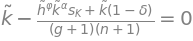

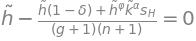

In [70]:
# defining all variables
ktilde = sm.symbols('ktilde')
htilde = sm.symbols('htilde')
sK = sm.symbols('s_K')
sH = sm.symbols('s_H')
delta = sm.symbols('delta')
g = sm.symbols('g')
n = sm.symbols('n')
alpha = sm.symbols('alpha')
varphi = sm.symbols('varphi')

#f = (ktilde**alpha)*(htilde**varphi) # defining f


# define transistion equations
tranK = sm.Eq(ktilde-(sK*((ktilde**alpha)*(htilde**varphi))+(1-delta)*ktilde)/((1+n)*(1+g)),0)
tranH = sm.Eq(htilde-(sH*((ktilde**alpha)*(htilde**varphi))+(1-delta)*htilde)/((1+n)*(1+g)),0)
#ss = sm.solve([tranK,tranH],[ktilde,htilde])
display(tranK)
display(tranH)
#SPØRG ANNE SOFIE
# solve for steady state
#ss = sm.solve(tranK, ktilde)
#ssh_k = sm.solve(tranH,)[0]


In [71]:
x = sm.symbols('x')
y = sm.symbols('y')
eq1 = sm.Eq(x**2+y-2,0)
eq2 = sm.Eq(y**2-4,0)
sol = sm.solve([eq1,eq2],[x,y])
sol

In [40]:
#tranK = sm.Eq(0, (1/((1+g)*(1+n)))*(sK*f-(n+g+delta+n*g)*ktilde))
#tranH = sm.Eq(0, (1/((1+g)*(1+n)))*(sH*f-(n+g+delta+n*g)*htilde))

## Numerical solution

You can always solve a model numerically. 

Define first the set of parameters you need. 

Then choose one of the optimization algorithms that we have gone through in the lectures based on what you think is most fitting for your model.

Are there any problems with convergence? Does the model converge for all starting values? Make a lot of testing to figure these things out. 

Based on "Introducing advanced macroeconomic" we find the plauseble values for out parameters. 
We assume a total savings rate of 20%, allined with teory, and therefor assume a savingsrate of 10% for each physical and human capital. We also have $\delta$ + $g$ should be 0,75, hence the values for the parameters is $\delta$ = 5% and $g$ = 2,5%. The population is assumed to increase with 10%. $\alpha$ and $\varphi$ is usual estimated to be $\frac{1}{3}$.


In [72]:
sK = 0.1
sH = 0.1
delta = 0.05
g = 0.025
n = 0.01
alpha = 1/3
varphi = 1/3

In [83]:
def k_star(htilde, sK, sH, g, n, delta, alpha, varphi, ktilde):
    return ((1/((1+n)*(1+g)))*(sK*ktilde**alpha*htilde**varphi-(n+g+delta+n*g)*ktilde))

def h_star(ktilde, sK, sH, g, n, delta, alpha, varphi, htilde):
    return ((1/((1+n)*(1+g)))*(sH*ktilde**alpha*htilde**varphi-(n+g+delta+n*g)*htilde))

obj1 = lambda x: [h_star(x[1], sK, sH, g, n, delta, alpha, varphi, x[0]), k_star(x[0], sK, sH, g, n, delta, alpha, varphi, x[1])]

solution = optimize.root(obj1, [1,1], method = 'broyden1')

In [84]:
num_sol = solution.x
print(num_sol)

[1.61404693 1.61404693]


In [74]:
# define
def kstar(htilde, sK, sH, delta, g, n, alpha, varphi):
    return ((sK**(1-varphi)*sH**varphi)/(n+g+delta+n*g))**(1/(1-alpha-varphi))

def hstar(sK, sH, delta, g, n, alpha, varphi):
    return ((sK**alpha*sH**(1-alpha))/(n+g+delta+n*g))**(1/(1-alpha-varphi))

obj1 = lambda x: [kstar(sK, sH, delta, g, n, alpha, varphi), tranH(sK, sH, delta, g, n, alpha, varphi)]

sol = optimize.root(obj1, [1,1], method='broyden1')

# hvad gør lambda funktionen. Simultane k* og h*
                        

/Users/helenethomsen/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_nonlin.py:911: RuntimeWarning: divide by zero encountered in true_divide
  d = v / vdot(df, v)


# Further analysis

Make detailed vizualizations of how your model changes with parameter values. 

Try to make an extension of the model. 

# Conclusion

Add concise conclusion. 